In [1]:
%matplotlib inline

In [2]:
import os

import matplotlib.pyplot as plt
import numpy as np
import cv2
import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets

In [19]:
def imshow(img):
    img = img / 4 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    # plt.savefig('figure.png')  # added for saving the image
    plt.show()

In [4]:
def show_images(raw, blurred):
    num = raw.shape[0]  # number of images
    fig, axes = plt.subplots(num, 2)
    axes[0][0].set_title('raw')
    axes[0][1].set_title('blurred')
    for i in range(num):
        axes[i][0].imshow(raw[i].transpose(1, 2, 0))
        axes[i][1].imshow(blurred[i].transpose(1, 2, 0))
    plt.show(fig)

In [5]:
def GaussianBlur_images(imgs, kernel_size, sigma):
    npimgs = imgs.numpy()
    imgs_list = []
    for img in npimgs:
         imgs_list.append(cv2.GaussianBlur(img.transpose(1, 2, 0), kernel_size, sigma))
    blurred_imgs = np.array(imgs_list)
    blurred_imgs = blurred_imgs.transpose(0, 3, 1, 2)
    return  torch.from_numpy(blurred_imgs)  # shape=(4, 3, 32, 32)

In [6]:
traindir = os.path.join('../../../data/ImageNet/ILSVRC2012/train')
valdir = os.path.join('../../../data/ImageNet/ILSVRC2012/val')
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                            std=[0.229, 0.224, 0.225])
train_dataset = datasets.ImageFolder(
        traindir,
        transforms.Compose([
            transforms.RandomResizedCrop(224),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            normalize,
        ]))

In [7]:
batch_size = 4
workers = 4
distributed = False
train_sampler = None

train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=batch_size, shuffle=(train_sampler is None),
        num_workers=workers, pin_memory=True, sampler=train_sampler)

val_loader = torch.utils.data.DataLoader(
        datasets.ImageFolder(valdir, transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            normalize,
        ])),
        batch_size=batch_size, shuffle=False,
        num_workers=workers, pin_memory=True)


In [28]:
dataiter = iter(train_loader)
images, target = dataiter.next()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([377, 910, 170,  53])


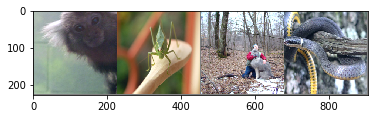

In [29]:
# show images
print(target)
imshow(torchvision.utils.make_grid(images))

In [30]:
images.size()

torch.Size([4, 3, 224, 224])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


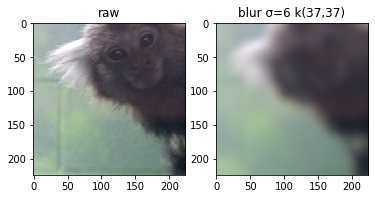

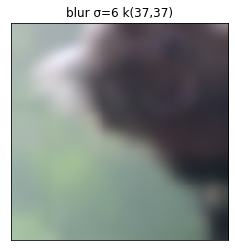

In [71]:
kernel_size=(0, 0)
sigma= 6
radius = sigma * 3 * 2+1
kernel_size=(radius, radius)
img = images[0]
img = img / 4 + 0.5 
npimg = img.numpy()
blur_file = 'blur_s{0}_k{1}-{1}.png'.format(sigma, kernel_size[0])
comp_file = 'blur_s{0}_k{1}-{1}_comparison.png'.format(sigma, kernel_size[0])
blur = cv2.GaussianBlur(npimg.transpose(1, 2, 0), kernel_size, sigma)
# cv2.imwrite('./blur_s3_k9-9.png', blur)

fig, axes = plt.subplots(1, 2)
axes[0].imshow(npimg.transpose(1, 2, 0))
axes[0].set_title('raw')
axes[1].imshow(blur)
axes[1].set_title('blur σ={0} k({1},{1})'.format(sigma, kernel_size[0]))
# axes[1].set_title('blur k({0},{0})'.format(kernel_size[0]))
# axes[1].set_title('blur σ={0}'.format(sigma))
plt.savefig(comp_file)
plt.show(fig)
# show and save an image
#plt.figure(figsize=(32,32))
# plt.subplots_adjust(left=0, right=1, bottom=0, top=1)
fig, axes = plt.subplots(1, 1)
plt.xticks([])
plt.yticks([])
axes.set_title('blur σ={0} k({1},{1})'.format(sigma, kernel_size[0]))
plt.imshow(blur)
plt.savefig(blur_file)  # added for saving the image
plt.show()

In [ ]:
kernel_size=(15, 15)
sigma= 5
blurs = GaussianBlur_images(images, kernel_size, sigma)

images = images / 2 + 0.5  # unnormalize
npimgs = images.numpy()
blurs = blurs / 2 + 0.5  # unnormalize
npblurs = blurs.numpy()

show_images(npimgs, npblurs)